In [18]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg
from numpy import polynomial
from numpy.polynomial import Polynomial
import pandas as pd
import scipy
import scipy.sparse
import scipy.sparse.linalg
import scipy.linalg
import scipy.optimize
import scipy.special
from sympy.ntheory import continued_fraction
import fractions
import tqdm.notebook
import sortednp
import ipywidgets as widgets
from IPython import display
import contfrac
%matplotlib inline

should_run_long_running_cells = True

In [13]:
def print_matrix(_mat):
    df = pd.DataFrame(_mat.toarray())
    display.display(df)

In [14]:
def poly2latex(func_name, p):
    if p.order == 0:
        c = p[0]
        if c >= 0:
            term = f'{c:.2g}'
        else:
            term = f'{c:+.2g}'
        return f'${func_name}(x)={term}$'

    terms = []
    for i, c in enumerate(p):
        if np.isclose(c,0):
            continue

        if i == p.order and not np.isclose(c, 0):
            term = f'{{{c:+.2g}}}'
        elif i == 0 and c >= 0:
            term = '' if np.isclose(c, 1) else f'{{{c:.2g}}}'
        else:
            term = '-' if np.isclose(c, -1) else f'{{{c:+.2g}}}'

        if i == p.order - 1:
            term += 'x'
        elif i < p.order - 1:
            term += f'x^{p.order - i}'
        terms.append(term)
    return f'${func_name}(x)={"".join(terms)}$'

def display_polynomial(name, p):
    display.display(display.Latex(poly2latex(name, p)))

ip = get_ipython()
latex_formatter = ip.display_formatter.formatters['text/latex']
latex_formatter.for_type_by_name('numpy.polynomial.polynomial',
                                 'Polynomial', lambda p: poly2latex('P', p))

## Plotting the Kohomoto butterfly

For some introduction
The Kohomoto butterfly is a plot of the spectrum of the discrete schrodinger operator on a quasiperiodic chain.

If we look at a function $f:\mathbb{Z}\to\mathbb{R}$ we can define for a given $\alpha \in (0,1)$ the operator
$H_\alpha$ which operates on the function $f$ and returns a function of the same kind
(which we will mark as $H_\alpha f$) like so:
$$[H_\alpha f](n) = f(n-1)+f(n+1)+V(n)f(n)$$
Where $V(n)$ is a function from the integers to the real numbers which is named the potential.
This potential is the quasiperiodic chain.

Now for a given $\alpha$ and a given $v$
$$V(n)=   \begin{cases}  v, \quad \text{  if   } \,\, 1-\alpha\leq z(n) < 1 \\ 0,  \quad \text{otherwise} \end{cases}$$
This $H_\alpha$ operator can be thought about as an infinite matrix where the diagonal is $V(n)$ and the superdiagonal
and subdiagonal are 1.
$$
H_\alpha =
\begin{pmatrix}
\ddots& &  &  &  &  &\\
&V(-2) & 1 & 0 & 0 & 0&\\
&1 & V(-1) & 1 & 0 & 0&\\
&0 & 1 & V(0) & 1 & 0 &\\
&0 & 0 & 1 & V(1) & 1 &\\
&0 & 0 & 0 & 1 & V(2) &\\
& &  &  &  &  & \ddots
\end{pmatrix}
$$
The spectrum of $H_\alpha$ can be thought of as its eigenvalues, the Kohomoto butterfly is a plot of $\alpha$ against
$H_\alpha$ spectrum.

We know how to draw the spectrum for a rational $\alpha$ and so that is what we will draw.
We will explore 2 ways to draw the butterfly.

* Using submatrices of $H_\alpha$
* With the Bloch theorem

### Plotting the butterfly with submatrices of $H_\alpha$

Let $\frac{p}{q}$ be the lowest term of the rational $\alpha$ then we know that $V(n)$ is periodic with a cycle of size q.
We will look at a submatrix of size $q\times q$ of $H_\alpha$.
We'll name the submatrix as $H_q$

In [4]:
def get_matrix_for_alpha(p, q, v=1):
    alpha = fractions.Fraction(p,q)
    p = alpha.numerator
    q = alpha.denominator
    na = np.arange(q) * alpha 
    na -= np.floor(na)
    v_n = np.where(na >= 1-alpha, v, 0)
    return scipy.sparse.diags([1, v_n, 1], [-1, 0, 1], shape=(q, q), dtype=np.int32)

Now we will parametrize $H_q$ with $\theta$ so for example for $q=5$ with some $V(n)$.
$$
H_q(\theta) =
\begin{pmatrix}
v & 1 & 0 & 0 & e^{-i\theta}\\
1 & v & 1 & 0 & 0\\
0 & 1 & 0 & 1 & 0\\
0 & 0 & 1 & 0 & 1\\
e^{i\theta} & 0 & 0 & 1 & v\\
\end{pmatrix}
$$

now for each $\theta$ we can get the eigenvalues of $H_q(\theta)$ and plot them against $\theta$
We should get $q$ separate plot lines.

Each plot line $g$ defines an interval $[\min(g), \max(g)]$ which is an interval in the spectrum of $H_\alpha$

In [5]:
def plot_spectrum_lines(_mat):
    thetas = np.linspace(0, 3, 1000)
    x = []
    y = []
    _mat = _mat.toarray()
    _mat = _mat.astype(np.complex128)
    q = _mat.shape[0]

    for theta in thetas:
        _mat[0][q-1] = np.exp(-1j*theta)
        _mat[q-1][0] = np.exp(1j*theta)
        x.extend([theta]*q)
        y.extend(scipy.linalg.eigvalsh(_mat))
    fig, ax = plt.subplots(figsize=(5,5))
    fig.subplots_adjust(.02,.02,.98,.9)
    ax.scatter(x, y, s=2)

So for $H_{5/7}$ we should get 7 plot lines and thus its spectrum consists of 7 separate intervals.

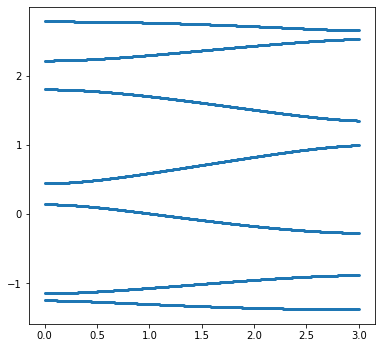

In [6]:
p = 5
q = 7
frac = fractions.Fraction(p, q)
mat = get_matrix_for_alpha(p, q)
plot_spectrum_lines(mat)

But it is known that we get $\min(g), \max(g)$ at $\theta=0$ and $\theta=\pi$ so we can calculate only them

In [7]:
def get_intervals_from_matrix(_mat, driver='ev'):
    _q = _mat.shape[0]
    
    diag_bl = np.diag([1], -_q+1)
    diag_tr = np.diag([1], _q-1)

    _mat += diag_bl
    _mat += diag_tr
    eig_zero = scipy.linalg.eigvalsh(_mat, driver=driver)
    _mat -= 2*diag_bl
    _mat -= 2*diag_tr
    eig_pi = scipy.linalg.eigvalsh(_mat, driver=driver)
    _mat += diag_bl
    _mat += diag_tr

    _intervals = sortednp.merge(eig_zero, eig_pi)
    _intervals.shape = (_q, 2)

    return _intervals

In [8]:
def get_spectral_radius(_mat):
    _q = _mat.shape[0]
    _mat_copy = _mat.asfptype()

    original = _mat_copy.diagonal(_q-1)
    _mat_copy.setdiag(original+1, _q-1)
    _mat_copy.setdiag(original+1, -_q+1)
    eig_zero = scipy.sparse.linalg.eigsh(_mat_copy, 1, return_eigenvectors=False, which='LA')

    original = _mat_copy.diagonal(_q-1)
    _mat_copy.setdiag(original-1, _q-1)
    _mat_copy.setdiag(original-1, -_q+1)
    eig_pi = scipy.sparse.linalg.eigsh(_mat_copy, 1, return_eigenvectors=False, which='LA')

    return np.maximum(np.absolute(eig_zero), np.absolute(eig_pi))


def get_spectrum_min_max(_mat):
    _q = _mat.shape[0]
    
    diag_bl = np.diag([1], -_q+1)
    diag_tr = np.diag([1], _q-1)

    _mat += diag_bl
    _mat += diag_tr
    min_zero = scipy.linalg.eigvalsh(_mat, subset_by_index=[0, 0], driver='evr')[0]
    max_zero = scipy.linalg.eigvalsh(_mat, subset_by_index=[_q-1, _q-1], driver='evr')[0]
    _mat -= 2*diag_bl
    _mat -= 2*diag_tr
    min_pi = scipy.linalg.eigvalsh(_mat, subset_by_index=[0, 0], driver='evr')[0]
    max_pi = scipy.linalg.eigvalsh(_mat, subset_by_index=[_q-1, _q-1], driver='evr')[0]
    _mat += diag_bl
    _mat += diag_tr
    
    _max = np.maximum(max_zero, max_pi)
    _min = np.minimum(min_zero, min_pi)

    return _min, _max

In [11]:
def print_matrix_intervals(mat):
    for x1, x2 in get_intervals_from_matrix(mat):
        print(f'({x1}, {x2})')


In [15]:
print(f'alpha={1}/{2}')
mat = get_matrix_for_alpha(1, 2)
print_matrix(mat)
print_matrix_intervals(mat)
print()
print(f'alpha={5}/{7}')
mat = get_matrix_for_alpha(5, 7)
print_matrix(mat)
print_matrix_intervals(mat)

alpha=1/2


,0,1
0,0,1
1,1,1


(-1.5615528128088303, 0.0)
(1.0, 2.5615528128088303)

alpha=5/7


,0,1,2,3,4,5,6
0,0,1,0,0,0,0,0
1,1,1,1,0,0,0,0
2,0,1,1,1,0,0,0
3,0,0,1,0,1,0,0
4,0,0,0,1,1,1,0
5,0,0,0,0,1,1,1
6,0,0,0,0,0,1,1


(-1.377202853972958, -1.2469796037174672)
(-1.1438644257528587, -0.8793852415718172)
(-0.2738905549642174, 0.14155804524315135)
(0.4450418679126287, 1.0000000000000007)
(1.3472963553338617, 1.8019377358048383)
(2.2183096530474744, 2.5320888862379545)
(2.651093408937176, 2.7839967274622315)


#### Actually plotting

Now to plot the entire butterfly we'll just choose a list of fractions for each fraction $\alpha$
calculate the spectrum of $H_\alpha$ and plot it as lines at $y=\alpha$

In [19]:
def contfrac_to_fraction(coefficients):
    numerator_2_ago = 0
    numerator_1_ago = 1
    denominator_2_ago = 1
    denominator_1_ago = 0
    for coefficient in coefficients:
        numerator = coefficient * numerator_1_ago + numerator_2_ago
        numerator_2_ago = numerator_1_ago
        numerator_1_ago = numerator
        denominator = coefficient * denominator_1_ago + denominator_2_ago
        denominator_2_ago = denominator_1_ago
        denominator_1_ago = denominator
    return fractions.Fraction(numerator, denominator)

In [24]:
def get_a_b_intervals(alpha, driver='evr', v=1):
    coefficients = list(contfrac.continued_fraction(alpha))
    alpha_A_type = contfrac_to_fraction(coefficients[:-1])
    coefficients[-1] -= 1
    alpha_B_type = contfrac_to_fraction(coefficients)
    mat_a = get_matrix_for_alpha(alpha_A_type.numerator, alpha_A_type.denominator, v)
    mat_b = get_matrix_for_alpha(alpha_B_type.numerator, alpha_B_type.denominator, v)
    a_intervals = get_intervals_from_matrix(mat_a, driver=driver)
    b_intervals = get_intervals_from_matrix(mat_b, driver=driver)

    return a_intervals, b_intervals

def is_interval_contained(interval, intervals):
    for a, b in intervals:
        if interval[0] > a and interval[1] < b:
            return True

    return False

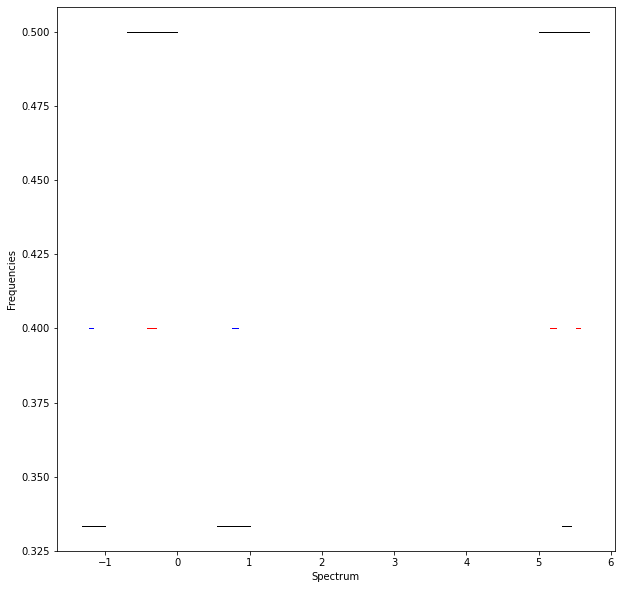

In [46]:
def plot_alpha(alpha, ax=None, *, linewidth=1, v=1, driver='ev', color_plot=False):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,10))
        ax.set_ylabel('Frequencies')
        ax.set_xlabel('Spectrum')
    color = 'k'
    if color_plot:
        a_intervals, b_intervals = get_a_b_intervals(alpha, driver=driver, v=v)
    mat = get_matrix_for_alpha(alpha.numerator, alpha.denominator, v)
    for x1, x2 in get_intervals_from_matrix(mat, driver=driver):
        interval = (x1, x2)
        if color_plot:
            if is_interval_contained(interval, a_intervals):
                color = 'r'
            elif is_interval_contained(interval, b_intervals):
                color = 'b'
            else:
                color = 'k'
        ax.plot(interval, [alpha, alpha], color + '-', linewidth=linewidth)

fig, ax = plt.subplots(figsize=(10,10))
ax.set_ylabel('Frequencies')
ax.set_xlabel('Spectrum')
alpha = fractions.Fraction(2, 5)
plot_alpha(alpha, ax, v=5, color_plot=True)   
coefficients = list(contfrac.continued_fraction(alpha))
alpha_A_type = contfrac_to_fraction(coefficients[:-1])
coefficients[-1] -= 1
alpha_B_type = contfrac_to_fraction(coefficients) 
plot_alpha(alpha_A_type, ax, v=5)   
plot_alpha(alpha_B_type, ax, v=5)   


In [11]:
def plot_butterfly(alphas, name, *, linewidth=0.1, dpi=400, v=1, driver='ev'):
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_yticks(np.linspace(0, 1, 21))
    counter = 0
    for alpha in tqdm.notebook.tqdm(alphas):
        plot_alpha(alpha, linewidth=linewidth, v=v, driver=driver)
    ax.plot([-2, 2], [0, 0], 'k-', linewidth=linewidth)
    ax.plot([-2 + v, 2 + v], [1, 1], 'k-', linewidth=linewidth)
    ax.set_ylabel('Frequencies \u03B1')
    ax.set_xlabel('Spectrum')
    fig.savefig(f'output/{name}.png', dpi=dpi)
    # fig.savefig(f'output/{name}.svg', format='svg')
    # fig.savefig(f'output/{name}.eps', format='eps')

In [14]:
def plot_spectral_radius(alphas, *, markersize=2):
    fig, ax = plt.subplots(2, figsize=(10,10))
    counter = 0
    max_radius = []
    min_radius = []
    for alpha in tqdm.notebook.tqdm(alphas):
        mat = get_matrix_for_alpha(alpha.numerator, alpha.denominator)
        _min, _max = get_spectrum_min_max(mat)
        max_radius.append(_max)
        min_radius.append(_min)
    print(min_radius)
    ax[0].plot(alphas, max_radius, 'o-', markersize=markersize)
    ax[0].set_title('max radius')
    ax[1].plot(alphas, min_radius, 'o-', markersize=markersize)
    ax[1].set_title('min radius')
    ax[1].get_yaxis().get_major_formatter().set_useOffset(False)

For choosing the fractions we'll try 2 lists

* Choose a list of denominators $q$ and for each we go over the fractions
$\frac{1}{q}$ to $\frac{q-1}{q}$.
We choose the denominators as the primes from $11$ to $n$ so we'll get unique fractions and
$2^3 \cdot 3^3,5^3,7^2$ to get more of the simpler fractions such as $\frac{1}{2}, \frac{2}{3}, \frac{1}{6}$ etc...

In [13]:
def primesfrom2to(n):
    """ Input n>=6, Returns a array of primes, 2 <= p < n """
    sieve = numpy.ones(n//3 + (n%6==2), dtype=numpy.bool)
    for i in range(1,int(n**0.5)//3+1):
        if sieve[i]:
            k=3*i+1|1
            sieve[       k*k//3     ::2*k] = False
            sieve[k*(k-2*(i&1)+4)//3::2*k] = False
    return numpy.r_[2,3,((3*numpy.nonzero(sieve)[0][1:]+1)|1)]

> **WARNING**: This is not super efficient so it might take some time


Wall time: 4min 21s


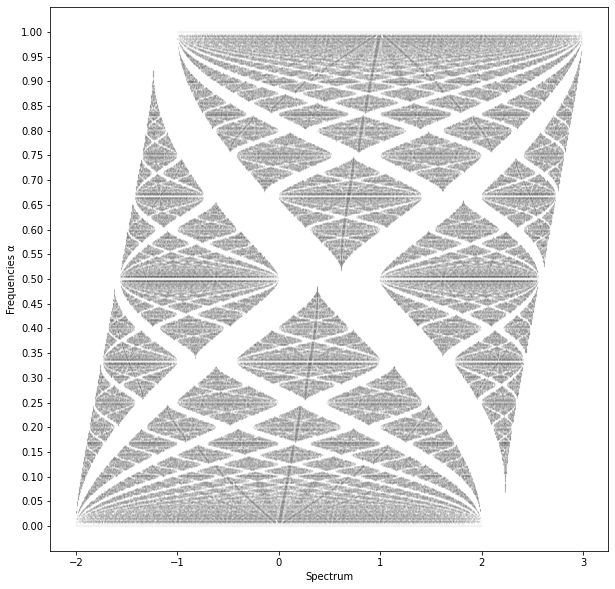

In [14]:
%%time

if should_run_long_running_cells:
    n = 150
    primes = primesfrom2to(n)[4:]
    primes = np.append(primes, (125, 49, 216))
    alphas = []
    for q in primes:
        for p in range(1, q):
            alphas.append(fractions.Fraction(p, q))
    plot_butterfly(alphas, f"primes_{n}")


[-1.999762842489739, -1.9997674251402424, -1.9997718762344399, -1.9997762007601467, -1.9997804034710105, -1.9997844888995833, -1.9997884613695467, -1.999792325007158, -1.9997960837519666, -1.9997997413668667, -1.9998033014475123, -1.9998067674311637, -1.9998101426049837, -1.9998134301138366, -1.999816632967617, -1.9998197540481388, -1.9998227961156256, -1.9998257618148103, -1.9998286536806886, -1.999831474143937, -1.999834225536023, -1.9998369100940248, -1.9998395299651774, -1.9998420872111726, -1.9998445838122139, -1.9998470216708486, -1.9998494026155993, -1.9998517284043889, -1.9998540007277885, -1.99985622121209, -1.9998583914222166, -1.999860512864483, -1.9998625869892057, -1.9998646151931865, -1.9998665988220616, -1.9998685391725384, -1.9998704374945109, -1.9998722949930747, -1.9998741128304407, -1.9998758921277533, -1.9998776339668187, -1.9998793393917502, -1.999881009410533, -1.9998826449965157, -1.9998842470898257, -1.9998858165987223, -1.9998873544008862, -1.999888861344642, 

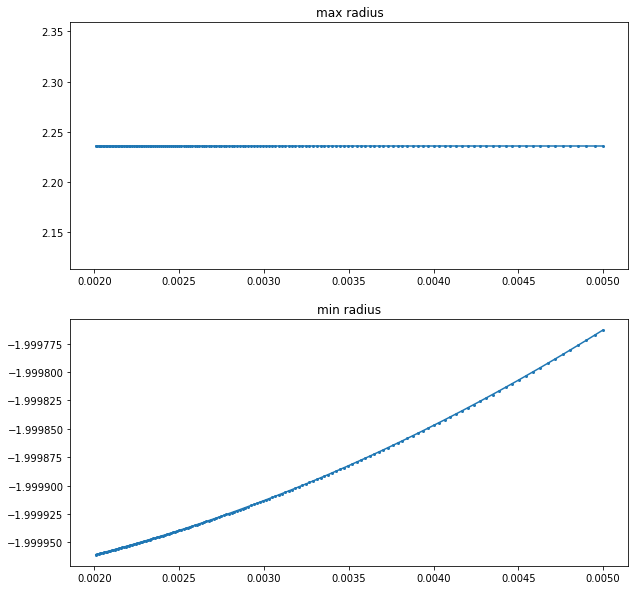

In [15]:
%%time

if should_run_long_running_cells:
    n = 500
    alphas = []
    for i in range(200, n, 2):
        alphas.append(fractions.Fraction(1, i))
    plot_spectral_radius(alphas)

In [21]:
%%time

if should_run_long_running_cells:
    n = 30
    alphas = []
    f_1 = 1
    f_2 = 2
    alpha = fractions.Fraction(f_1, f_2)
    print(alpha, end=": ")
    r = get_spectral_radius(get_matrix_for_alpha(alpha.numerator, alpha.denominator))
    print(r)
    r_prev = None
    points = []
    for i in tqdm.tqdm(range(n)):
        r_prev = r

        temp = f_2
        f_2 = f_1 + f_2
        f_1 = temp

        alpha = fractions.Fraction(temp, f_2)
        print(alpha, end=": ")
        r = get_spectral_radius(get_matrix_for_alpha(alpha.numerator, alpha.denominator))
        print(r)
        points.append(f_1*np.absolute(r - r_prev))

    plt.plot(np.arange(len(points)), points)
    # plot_spectral_radius(alphas)

 57%|█████▋    | 17/30 [20:10<15:25, 71.19s/it] 


1/2: [3.54294504]
2/3: [2.73205081]
3/5: [2.67513087]
5/8: [2.69962815]
8/13: [2.69182953]
13/21: [2.69522955]
21/34: [2.70384093]
34/55: [2.69777177]
55/89: [2.71007389]
89/144: [2.70863962]
144/233: [2.70254254]
233/377: [2.70497865]
377/610: [2.70054564]
610/987: [2.71090896]
987/1597: [2.70201774]
1597/2584: [2.69806713]
2584/4181: [2.703821]
4181/6765: [2.69485293]
6765/10946: 

ArpackNoConvergence: ARPACK error -1: No convergence (109461 iterations, 0/1 eigenvectors converged)

* Farey sequence - this sequence of order n is the sequence of completely reduced fractions between 0 and 1

  The asymptotic behaviour of $|Fn|$ is: $$|F_{n}| \sim \frac{3n^2}{\pi^2}$$

In [36]:
def farey_sequence(n: int, descending: bool = False, print_ends: bool = False):
    """Generator for the n'th Farey sequence. with or without 0 and 1, Allow for either ascending or descending."""
    (a, b, c, d) = (0, 1, 1, n)
    c_end = n if print_ends else n-1
    if descending:
        (a, c) = (1, n - 1)
    if print_ends:
        yield fractions.Fraction(a, b)
    while (c <= c_end and not descending) or (a > 0 and descending):
        k = (n + b) // d
        (a, b, c, d) = (c, d, k * c - a, k * d - b)
        if a != 0 and a != b:
            yield fractions.Fraction(a, b)

> **WARNING**: This is not super efficient so it might take some time

In [ ]:
%%time
if should_run_long_running_cells:
    n = 250 # This will be 6857 fractions
    plot_butterfly(list(farey_sequence(n)), f"farey_{n}", linewidth=0.005,dpi=1000)

### Plotting the butterfly with the Bloch theorem

We'll be using the map relations:
$$
\begin{align}
x_{k+1} & = z_k S_{a_{k+1}-1}(x_k)-y_k S_{a_{k+1}-2}(x_k) \\\
y_{k+1} & = x_k \\\
z_{k+1} & = z_k S_{a_{k+1}}(x_k)-y_k S_{a_{k+1}-1}(x_k)
\end{align}
$$
 
Where $S_l$ denotes the $l^\underline{th}$  Chebischev polynomial of the second kind 
$$
\begin{align}
S_{-1}(x) & = 0 \\\
S_{0}(x) & = 1 \\\
S_{l+1}(x) & = xS_{l}(x)-S_{l-1}(x),\forall l\geq0
\end{align}
$$

We use the `scipy.special.eval_chebys` function

In [18]:
def print_map_relations(index, x, y, z):
    print(f'x{index}={x}, y{index}={y}, z{index}={z}')

In [19]:
def calculate_trace(E, cr, verbose=False):
    E = np.float64(E)
    x = E
    y = 2
    z = E-1
    if verbose: print_map_relations(0, x, y, z)
    for index, a in enumerate(cr):
        x_prev = x
        y_prev = y
        z_prev = z
        a = int(a)
        S = scipy.special.eval_chebys((a, a-1, a-2), (x_prev,))

        x = np.multiply(z_prev, S[1])-np.multiply(y_prev, S[2])
        y = x_prev
        z = np.multiply(z_prev, S[0])-np.multiply(y_prev, S[1])
        if verbose: print_map_relations(index + 1, x, y, z)
    return x

In [20]:
p = 2
q = 3
frac = fractions.Fraction(p, q)
cr = continued_fraction(frac)[1:]
mat = get_matrix_for_alpha(p, q)
trace = calculate_trace(2.56155, cr, verbose=True)
print(trace)
print_matrix_intervals(mat)
# for a, b in get_ranges(mat):\n",
#     print(calculate_trace(a, cr))\n",
#     print(calculate_trace(b, cr))"

x0=2.56155, y0=2, z0=1.56155
x1=1.56155, y1=2.56155, z1=1.9999884025
x2=0.561531889923875, y2=1.56155, z2=-1.123128279789373
0.561531889923875
(-1.4142135623730951, -0.7320508075688775)
(-1.1102230246251573e-16, 1.4142135623730951)
(1.9999999999999998, 2.7320508075688767)


In [21]:
def find_roots(f, values_space, verbose=False):
    c = f(values_space)
    s = numpy.sign(c)
    roots = []
    for i in range(1000-1):
        if s[i] + s[i+1] == 0: # oposite signs\n",
            u = scipy.optimize.brentq(f, values_space[i], values_space[i+1])
            z = f(u)
            if numpy.isnan(z) or abs(z) > 1e-3:
                continue
            roots.append(u)
            if verbose: print('found zero at {}'.format(u))

    return np.array(roots)

In [22]:
def get_intervals_from_cr_using_calculate_trace_func(cr, values_space):
    vcalculate_trace = np.vectorize(calculate_trace, excluded=['cr'])
    vcalculate_trace.excluded.add(1)
    low_roots = find_roots(lambda x: vcalculate_trace(x, cr)-2, values_space)
    high_roots = find_roots(lambda x: vcalculate_trace(x, cr)+2, values_space)
    _ranges = sortednp.merge(low_roots, high_roots)
    _ranges.shape = (len(_ranges)//2, 2)

    return _ranges

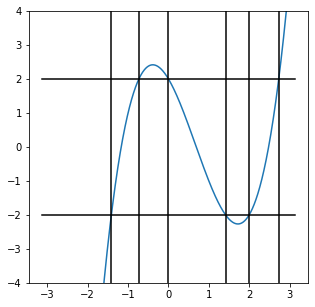

In [23]:
p = 2
q = 3
frac = fractions.Fraction(p, q)
cr = continued_fraction(frac)[1:]
mat = get_matrix_for_alpha(p, q)

values_space = np.linspace(-2,3, 1000)
vcalculate_trace = np.vectorize(calculate_trace, excluded=['cr'])
vcalculate_trace.excluded.add(1)
traces = vcalculate_trace(E=values_space, cr=cr)

fig, ax = plt.subplots(figsize=(5,5))
ax.set_ylim(bottom=-4, top=4)

ax.plot(values_space, traces)
ax.plot([-np.pi, np.pi], [2, 2], 'k-')
ax.plot([-np.pi, np.pi], [-2, -2], 'k-')

for a,b in get_intervals_from_matrix(mat):
    plt.plot([a, a], [-4, 4], 'k-')
    plt.plot([b, b], [-4, 4], 'k-')

In [24]:
%%time 
int1 = get_intervals_from_matrix(mat)

Wall time: 979 µs


In [25]:
%%time
int2 = get_intervals_from_cr_using_calculate_trace_func(cr, values_space)

Wall time: 272 ms


In [26]:
def get_chebyshev_coeff(degree):
    if degree == -1:
        return np.poly1d([0])
    cheb_poly = scipy.special.chebyu(degree, monic=False)
    return cheb_poly(np.poly1d([0.5, 0]))

def calculate_trace_polynomial(cr, verbose=False):
    x = np.poly1d([1, 0])
    y = np.poly1d([2])
    z = np.poly1d([1, -1])
    if verbose:
        display_polynomial('x_0', x)
        display_polynomial('y_0', y)
        display_polynomial('z_0', z)
    for index, a in enumerate(cr):
        x_prev = x
        y_prev = y
        z_prev = z
        a = int(a)
        S = [
            get_chebyshev_coeff(a),
            get_chebyshev_coeff(a-1),
            get_chebyshev_coeff(a-2)
        ]

        x = z_prev * S[1](x_prev)-y_prev * S[2](x_prev)
        y = x_prev
        z = z_prev * S[0](x_prev)-y_prev * S[1](x_prev)
        if verbose:
            display_polynomial(f'x_{index}', x)
            display_polynomial(f'y_{index}', y)
            display_polynomial(f'z_{index}', z)
    return x

<IPython.core.display.Latex object>

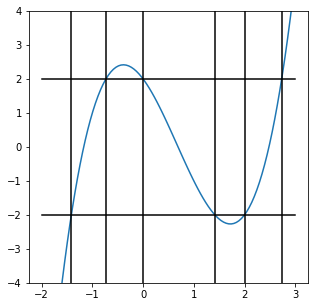

In [27]:
p = 2
q = 3
frac = fractions.Fraction(p, q)
cr = continued_fraction(frac)[1:]
mat = get_matrix_for_alpha(p, q)

trace_p = calculate_trace_polynomial(cr)
display_polynomial(f'p_{{{frac}}}', trace_p)
x = np.linspace(-2, 3, 100)
y = trace_p(x)

fig, ax = plt.subplots(figsize=(5,5))
ax.set_ylim(bottom=-4, top=4)
ax.plot(x, y)
ax.plot([-2, 3], [2, 2], 'k-')
ax.plot([-2, 3], [-2, -2], 'k-')

for a,b in get_intervals_from_matrix(mat):
    plt.plot([a, a], [-4, 4], 'k-')
    plt.plot([b, b], [-4, 4], 'k-')

In [28]:
def get_intervals_from_cr_using_calculate_trace_polynomial(cr):
    poly = calculate_trace_polynomial(cr)
    low_roots = (poly-2).roots
    high_roots = (poly+2).roots

    _intervals = np.concatenate((low_roots, high_roots))
    _intervals.sort()
    _intervals.shape = (len(_intervals)//2, 2)

    return _intervals

In [29]:
p = 2
q = 10
frac = fractions.Fraction(p, q)
cr = continued_fraction(frac)[1:]
mat = get_matrix_for_alpha(p, q)

int1 = get_intervals_from_matrix(mat)
int2 = get_intervals_from_cr_using_calculate_trace_polynomial(cr)

In [30]:
def get_matrix_for_cr(cr, E, V=1):
    M_prev = np.array([(1, -V), (0, 1)])
    M = np.array([(E, -1), (1, 0)])
    for a in cr:
        a = int(a)
        M_next = np.matmul(M_prev, np.linalg.matrix_power(M, a))
        M_prev = M
        M = M_next

    return M

def get_trace_from_matrix_cr(E, cr, V=1):
    mat = get_matrix_for_cr(cr, E, V)
    return mat[0][0] + mat[1][1]

In [31]:
def get_intervals_from_cr_using_get_trace_from_matrix_cr_func(cr, values_space):
    vcalculate_trace = np.vectorize(get_trace_from_matrix_cr, excluded=['cr', 'V'])
    vcalculate_trace.excluded.add(1)
    vcalculate_trace.excluded.add(2)
    low_roots = find_roots(lambda x: vcalculate_trace(x, cr, 1)-2, values_space)
    high_roots = find_roots(lambda x: vcalculate_trace(x, cr, 1)+2, values_space)
    _ranges = sortednp.merge(low_roots, high_roots)
    _ranges.shape = (len(_ranges)//2, 2)

    return _ranges

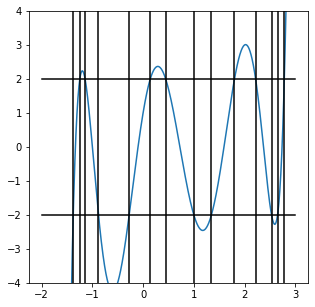

In [32]:
p = 5
q = 7
frac = fractions.Fraction(p, q)
cr = continued_fraction(frac)[1:]
mat = get_matrix_for_alpha(p, q)

values_space = np.linspace(-2,3, 1000)
vcalculate_trace = np.vectorize(get_trace_from_matrix_cr, excluded=['cr', 'V'])
vcalculate_trace.excluded.add(1)
vcalculate_trace.excluded.add(2)
traces = vcalculate_trace(E=values_space, cr=cr, V=1)

fig, ax = plt.subplots(figsize=(5,5))
ax.set_ylim(bottom=-4, top=4)

ax.plot(values_space, traces)
ax.plot([-2, 3], [2, 2], 'k-')
ax.plot([-2, 3], [-2, -2], 'k-')

for a,b in get_intervals_from_matrix(mat):
    plt.plot([a, a], [-4, 4], 'k-')
    plt.plot([b, b], [-4, 4], 'k-')

In [33]:
%%time
int1 = get_intervals_from_matrix(mat)

Wall time: 998 µs


In [35]:
%%time
int2 = get_intervals_from_cr_using_get_trace_from_matrix_cr_func(cr, values_space)



Wall time: 90 ms


In [42]:
alphas = farey_sequence(150)
for alpha in alphas:
    coeff = list(contfrac.continued_fraction(alpha))
    if coeff[-1] == 1:
        print(alpha)
